In [1]:
library(coloc)
library(data.table)
library(tidyverse)

This is a new update to coloc.

── Attaching packages ───────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.4.1     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.0.6
✔ tidyr   1.1.3     ✔ stringr 1.5.0
✔ readr   2.1.4     ✔ forcats 1.0.0

── Conflicts ──────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()   masks data.table::between()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::first()     masks data.table::first()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::last()      masks data.table::last()
✖ purrr::transpose() masks data.table::transpose()



### ASD XRN2 example

In [2]:
test_table <- read.table("ASD.iPSYCHPGC.2018_loci.tsv", header = T)
test_table

Warning message in read.table("ASD.iPSYCHPGC.2018_loci.tsv", header = T):
“incomplete final line found by readTableHeader on 'ASD.iPSYCHPGC.2018_loci.tsv'”


locus,CHR,BP
<int>,<int>,<int>
1,20,21248116
2,8,10576775
3,20,14836243


In [3]:
chr <- 20
bp <- 21248116

In [4]:
gwas_sumstats <- fread("/u/project/gandalm/shared/GWAS/ASD.Grove.iPSYCHPGC.2019/ASD.iPSYCHPGC.2018.filtered.tsv.gz", data.table = F)
gwas_sumstats <- gwas_sumstats %>% filter(CHROM == chr, POS > bp-1000000, POS < bp+1000000)

In [5]:
full_assoc <- fread(paste0("/u/project/gandalm/cindywen/isoform_twas/eqtl_new/results/mixed_nominal_90hcp/gtex_chr", chr, ".txt.gz"), data.table = F, sep = "\t")
full_sig <- fread("/u/project/gandalm/cindywen/isoform_twas/eqtl_new/results/mixed_nominal_90hcp/significant_assoc.txt", data.table = F)

In [6]:
colnames(full_assoc) <- c("gene_id", "variant_id", "tss_distance", "ma_samples", "ma_count", "maf", "pval_nominal", "slope", "slope_se")

In [7]:
qtl_bim <- fread("/u/project/gandalm/cindywen/isoform_twas/genotype/all_data/isec_R2_greater_than_3/ancestry/test.bim", data.table = F)

In [8]:
full_assoc <- full_assoc %>% inner_join(qtl_bim, by = c("variant_id" = "V2"))
full_assoc <- full_assoc %>% unite("pair", gene_id, variant_id, sep = "-", remove = FALSE)
full_sig <- full_sig %>% unite("pair", pid, sid, sep = "-", remove = FALSE)
sig_assoc <- full_assoc %>% filter(pair %in% full_sig$pair)
sig_locus <- sig_assoc %>% filter(variant_id %in% gwas_sumstats$ID)

In [9]:
unique(sig_locus$gene_id)

[1] "ENSG00000173418" "ENSG00000188559" "ENSG00000234104" "ENSG00000225127"
[5] "ENSG00000088970" "ENSG00000088930" "ENSG00000278041"

In [10]:
eur_1kg <- fread(paste0("/u/project/gandalm/shared/LDSCORE/1000G_EUR_Phase3_plink/1000G.EUR.QC.", chr, ".bim"), data.table = F)

In [11]:
# XRN2 ENSG00000088930
gene <- 'ENSG00000088930'

In [12]:
gene_full_assoc <- full_assoc %>% filter(gene_id == gene)
        
shared <- gene_full_assoc %>% 
            inner_join(gwas_sumstats, by = c("variant_id" = "ID")) %>% 
            inner_join(eur_1kg, by = c("variant_id" = "V2"))
dim(shared)

[1] 1564   31

In [13]:
head(shared)

,pair,gene_id,variant_id,tss_distance,ma_samples,ma_count,maf,pval_nominal,slope,slope_se,...,INFO,OR,SE,PVAL,BETA,V1.y,V3.y,V4.y,V5.y,V6.y
,<chr>,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<int>,<chr>,<chr>
1,ENSG00000088930-rs6047038,ENSG00000088930,rs6047038,-535521,384,473,0.3759940,0.601459,-0.00749442,0.0143402,...,0.985,0.99710,0.0143,0.83740,-0.002904213,20,47.47879,20748448,T,G
2,ENSG00000088930-rs6082152,ENSG00000088930,rs6082152,-535240,25,25,0.0198728,0.745567,0.01599710,0.0492735,...,0.904,0.92321,0.0505,0.11330,-0.079898551,20,47.47898,20748729,G,A
3,ENSG00000088930-rs1831005,ENSG00000088930,rs1831005,-534998,460,612,0.4864860,0.593434,-0.00702416,0.0131492,...,0.976,1.00793,0.0141,0.57660,0.007898723,20,47.47915,20748971,C,T
4,ENSG00000088930-rs4814987,ENSG00000088930,rs4814987,-534663,328,405,0.3219400,0.919617,-0.00148410,0.0146992,...,0.980,0.99810,0.0145,0.89500,-0.001901807,20,47.47938,20749306,A,G
5,ENSG00000088930-rs62202204,ENSG00000088930,rs62202204,-533688,109,110,0.0874404,0.762615,-0.00752918,0.0249142,...,0.946,0.96252,0.0207,0.06465,-0.038200434,20,47.48006,20750281,A,G
6,ENSG00000088930-rs6082154,ENSG00000088930,rs6082154,-531796,49,49,0.0389507,0.910645,-0.00394177,0.0351072,...,0.927,0.98876,0.0483,0.81570,-0.011303646,20,47.48137,20752173,T,C


In [13]:
shared <- shared %>% filter((V5.x == V5.y & V6.x == V6.y) | (V5.x == V6.y & V6.x == V5.y))
shared[which(shared$V5.x == shared$V6.y & shared$V6.x == shared$V5.y),'slope'] <- -shared[which(shared$V5.x == shared$V6.y & shared$V6.x == shared$V5.y),'slope']
shared <- shared %>% filter((A1 == V5.y & A2 == V6.y) | (A1 == V6.y & A2 == V5.y))
shared[which(shared$A1 == shared$V6.y & shared$A2 == shared$V5.y),'BETA'] <- -shared[which(shared$A1 == shared$V6.y & shared$A2 == shared$V5.y),'BETA']
shared <- shared %>% arrange(POS) 

In [14]:
snps <- as.data.frame(shared$variant_id)
colnames(snps)[1] <- "V1"
# write.table(snps, "/u/scratch/c/cindywen/xrn2_snps.txt", col.names = F, row.names = F, quote = F, sep = "\t")

In [15]:
# qtl_ld <- fread("../out/ASD.iPSYCHPGC.2018/locus1/ENSG00000088930_fetal_eqtl.ld", data.table = F)
qtl_ld <- fread("/u/scratch/c/cindywen/xrn2_fetal_eqtl.ld", data.table = F)

In [16]:
# gwas_ld <- fread("../out/ASD.iPSYCHPGC.2018/locus1/ENSG00000088930_fetal_eqtl_gwas.ld", data.table = F)
gwas_ld <- fread("/u/scratch/c/cindywen/xrn2_gwas.ld", data.table = F)

In [17]:
dim(qtl_ld)
dim(gwas_ld)

[1] 1564 1564

[1] 1564 1564

In [18]:
colnames(qtl_ld) <- rownames(qtl_ld) <- shared$variant_id
colnames(gwas_ld) <- rownames(gwas_ld) <- shared$variant_id

In [20]:
feature_data <- list("beta" = shared$slope,
                     "varbeta" = shared$slope_se * shared$slope_se,
                     "snp" = shared$variant_id,
                     "position" = shared$POS,
                     "type" = "quant",
                     "sdY" = 1, 
                     "LD" = as.matrix(qtl_ld))
gwas_data <- list("beta" = shared$BETA,
                  "varbeta" = shared$SE * shared$SE,
                  "snp" = shared$variant_id,
                  "position" = shared$POS,
                  "type" = "quant",
                  "sdY" = 1,
                  "LD" = as.matrix(gwas_ld))

In [87]:
check_dataset(feature_data, warn.minp = 1e-10)

NULL

In [88]:
check_dataset(gwas_data, warn.minp = 1e-10)

Warning message in check_dataset(gwas_data, warn.minp = 1e-10):
“minimum p value is: 7.7515e-09
If this is what you expected, this is not a problem.
If this is not as small as you expected, please check the 02_data vignette.”


NULL

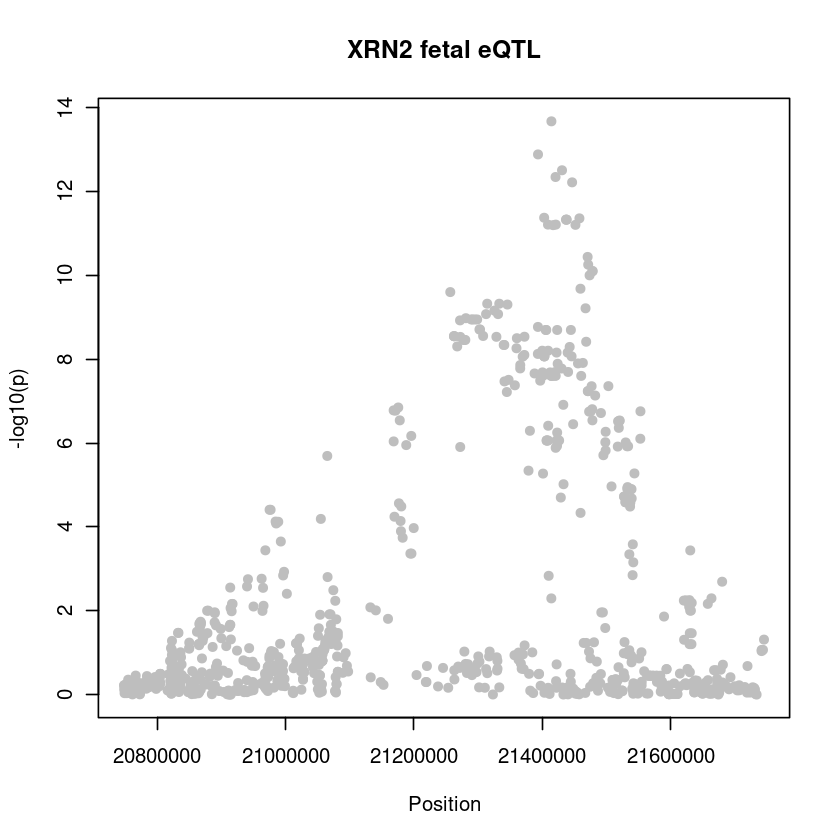

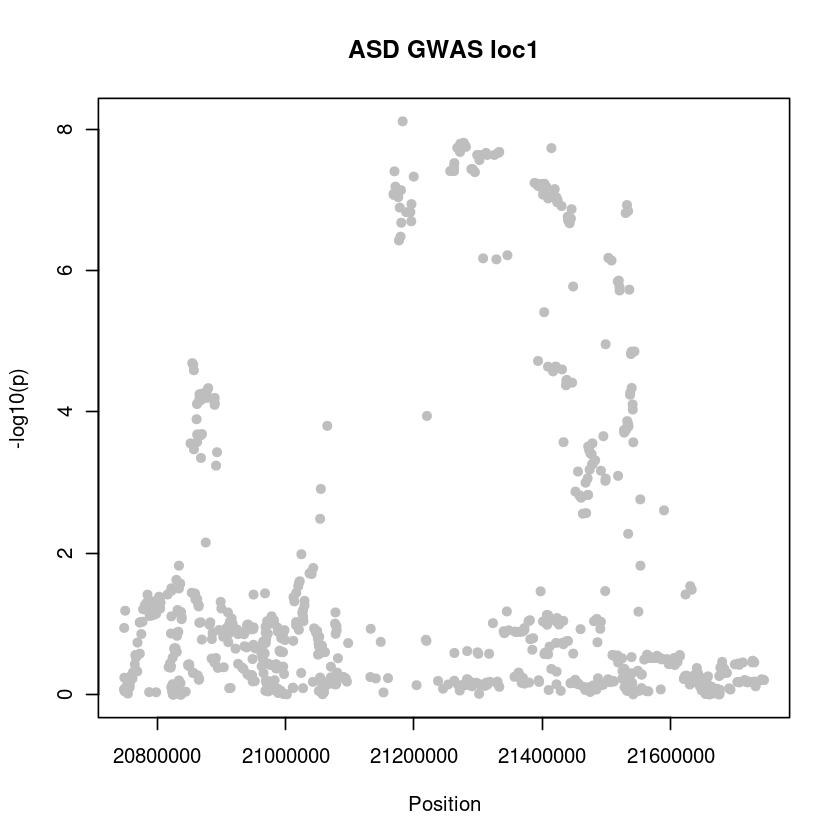

In [24]:
# 500kb
plot_dataset(feature_data, main = "XRN2 fetal eQTL")
plot_dataset(gwas_data, main = "ASD GWAS loc1")

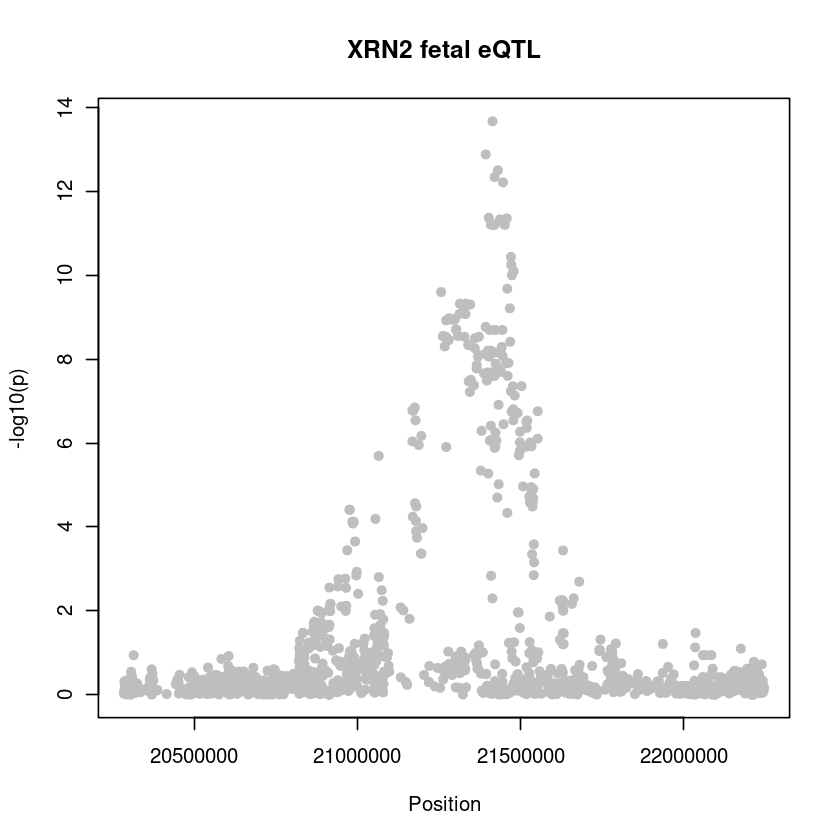

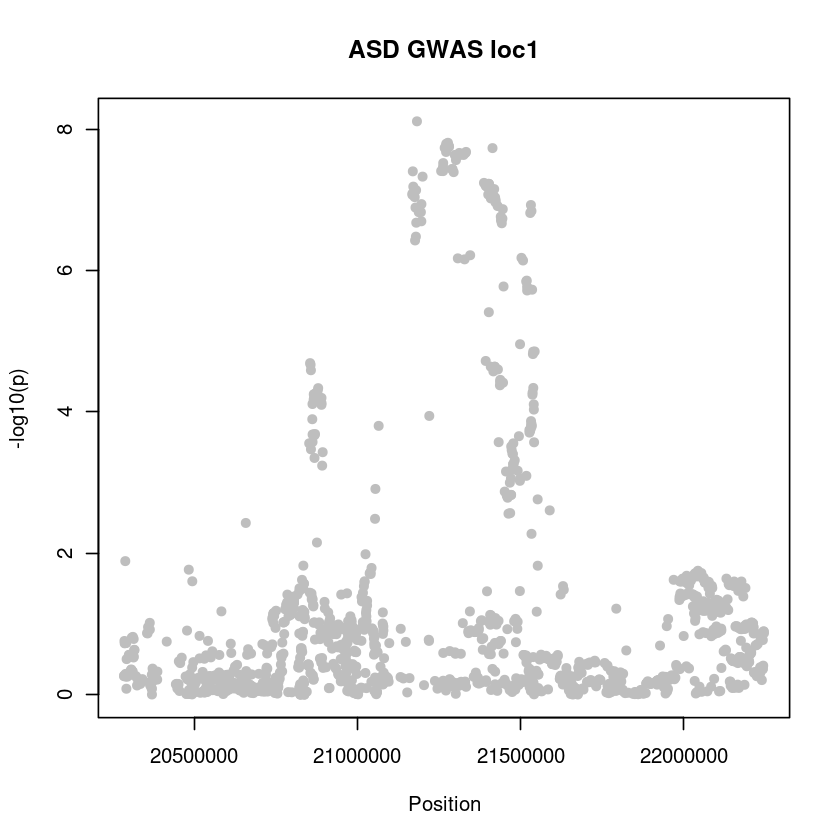

In [89]:
# 1mb
plot_dataset(feature_data, main = "XRN2 fetal eQTL")
plot_dataset(gwas_data, main = "ASD GWAS loc1")

### single causal

In [26]:
# 500kb
res <- coloc.abf(dataset1 = feature_data, dataset2 = gwas_data)
print(res)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 4.02e-13  1.96e-05  9.18e-10  4.37e-02  9.56e-01 
[1] "PP abf for shared variant: 95.6%"


Coloc analysis of trait 1, trait 2


SNP Priors



   p1    p2   p12 
1e-04 1e-04 1e-05 



Hypothesis Priors



        H0     H1     H2        H3      H4
 0.8095123 0.0871 0.0871 0.0075777 0.00871



Posterior



       nsnps           H0           H1           H2           H3           H4 
8.710000e+02 4.019193e-13 1.956855e-05 9.176287e-10 4.372102e-02 9.562594e-01 


In [21]:
# 1mb
res <- coloc.abf(dataset1 = feature_data, dataset2 = gwas_data)
print(res)

PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 4.02e-13  1.96e-05  9.18e-10  4.37e-02  9.56e-01 
[1] "PP abf for shared variant: 95.6%"


Coloc analysis of trait 1, trait 2


SNP Priors



   p1    p2   p12 
1e-04 1e-04 1e-05 



Hypothesis Priors



        H0     H1     H2         H3      H4
 0.6471147 0.1564 0.1564 0.02444532 0.01564



Posterior



       nsnps           H0           H1           H2           H3           H4 
1.564000e+03 4.019190e-13 1.956854e-05 9.176415e-10 4.372164e-02 9.562588e-01 


### susie finemapping on the shared variants

In [22]:
library(susieR)

### susie coloc

In [91]:
check_dataset(feature_data, req = "LD")
check_dataset(gwas_data, req = "LD")

NULL

NULL

In [51]:
if(requireNamespace("susieR",quietly=TRUE)) {
  ?susieR::susie_rss
}

susie_rss {susieR},R Documentation
z,A p-vector of z scores.
R,"A p by p symmetric, positive semidefinite correlation matrix."
z_ld_weight,"This parameter is included for backwards compatibility with previous versions of the function, but it is no longer recommended to use a non-zero value. If z_ld_weight > 0, the matrix R used in the model is adjusted to be cov2cor((1-w)*R + w*tcrossprod(z)), where w = z_ld_weight."
L,"Maximum number of components (nonzero coefficients) in the susie regression model. If L is larger than the number of covariates, p, L is set to p."
prior_variance,"The prior variance(s) for the non-zero element of b_l. It is either a scalar, or a vector of length L. When estimate_prior_variance = TRUE (highly recommended) this simply provides an initial value for the prior variance, and the default value of 50 is simply intended to be a large initial value."
estimate_prior_variance,"If estimate_prior_variance = TRUE, which is highly recommended, the prior variance is estimated (this is a separate parameter for each of the L effects). If provided, prior_variance is then used as an initial value for the optimization. When estimate_prior_variance = FALSE (not recommended) the prior variance for each of the L effects is determined by the value supplied to prior_variance."
...,Other parameters to be passed to susie_suff_stat.
alpha,An L by p matrix of posterior inclusion probabilites.
mu,"An L by p matrix of posterior means, conditional on inclusion."
mu2,"An L by p matrix of posterior second moments, conditional on inclusion."


### run susieR

In [107]:
library(susieR)
susier_qtl <- susie_rss(z=(shared$slope/shared$slope_se), R=as.matrix(qtl_ld))

In [110]:
summary(susier_qtl)

,variable,variable_prob,cs
,<dbl>,<dbl>,<dbl>
665,665,1.000000e+00,7
694,694,1.000000e+00,6
986,986,1.000000e+00,10
1039,1039,1.000000e+00,3
1040,1040,1.000000e+00,2
920,920,7.583393e-01,1
926,926,1.719023e-01,1
898,898,4.381292e-02,1
882,882,2.242371e-02,-1


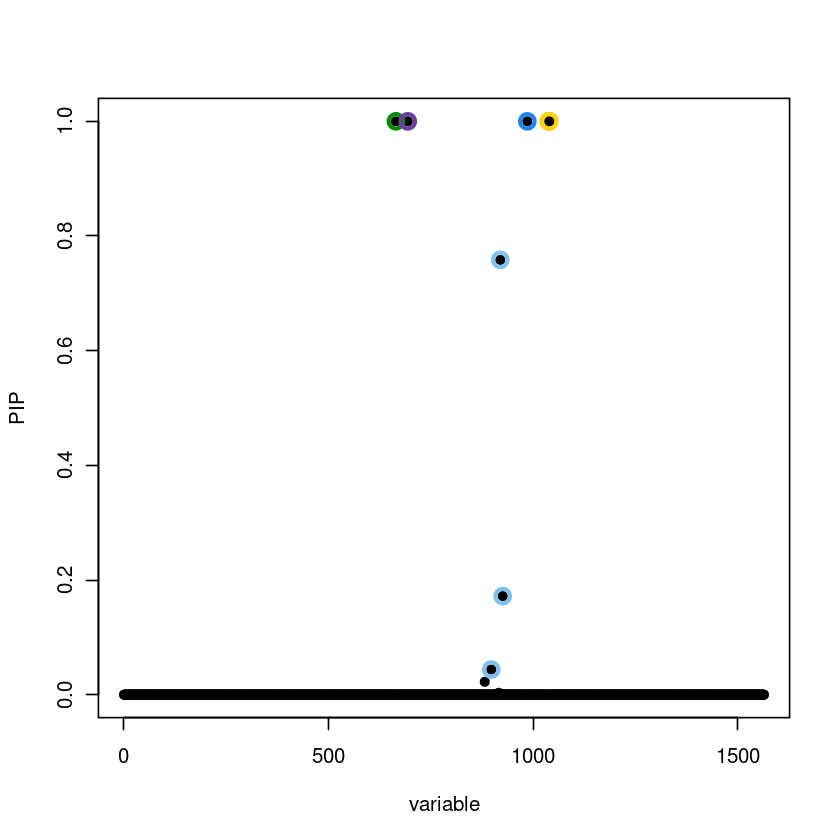

In [112]:
susie_plot(susier_qtl, y = "PIP")

In [113]:
susier_gwas <- susie_rss(z=(shared$BETA/shared$SE), R=as.matrix(gwas_ld))

In [114]:
summary(susier_gwas)$cs

NULL

### xrn2 susieR:susie finemapping results

In [115]:
res <- fread("~/project-gandalm/isoform_twas/eqtl_new/results/susie_finemap/mixed/mixed_ciseqtl_90hcp_perm_purity_filtered.txt.gz", data.table = F)

In [116]:
head(res)

,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000166024,chr10_100003785_T_C,10,100003785,T,C,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.068322868,-6.900330,0.8706241,0.9776713,24,-0.012146753,0.04585326,6.840422
2,ENSG00000166024,chr10_100008436_G_A,10,100008436,G,A,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.021124867,-6.704314,0.8706241,0.9776713,24,-0.003453998,0.02464589,6.840422
3,ENSG00000166024,chr10_100011970_G_A,10,100011970,G,A,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.021124867,-6.704314,0.8706241,0.9776713,24,-0.003453998,0.02464589,6.840422
4,ENSG00000166024,chr10_100013244_A_C,10,100013244,A,C,ENSG00000166024_L1,L1,chr10:98894380-100894380,0.050424642,-6.848917,0.8706241,0.9776713,24,-0.008776639,0.03908357,6.840422
5,ENSG00000119943,chr10_100164441_T_C,10,100164441,T,C,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.008835407,7.490109,0.6954467,0.9374778,42,0.002248738,0.02611878,9.666004
6,ENSG00000119943,chr10_100164442_A_G,10,100164442,A,G,ENSG00000119943_L1,L1,chr10:99174938-101174938,0.008835407,7.490109,0.6954467,0.9374778,42,0.002248738,0.02611878,9.666004


In [117]:
xrn2 <- res %>% filter(phenotype_id == 'ENSG00000088930')
head(xrn2)

,phenotype_id,variant_id,chr,pos,ref,alt,cs_id,cs_index,finemapped_region,pip,z,cs_min_r2,cs_avg_r2,cs_size,posterior_mean,posterior_sd,cs_log10bf
,<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,ENSG00000088930,chr20_21278890_C_CAA,20,21278890,C,CAA,ENSG00000088930_L1,L1,chr20:20283968-22283968,0.03844611,-9.404784,0.944666,0.9732944,3,-0.004418589,0.02222714,15.97722
2,ENSG00000088930,chr20_21310473_C_CA,20,21310473,C,CA,ENSG00000088930_L1,L1,chr20:20283968-22283968,0.08801340,-9.505051,0.944666,0.9732944,3,-0.010373229,0.03359398,15.97722
3,ENSG00000088930,chr20_21326578_A_AT,20,21326578,A,AT,ENSG00000088930_L1,L1,chr20:20283968-22283968,0.84275136,-9.775956,0.944666,0.9732944,3,-0.101061894,0.04509842,15.97722


### 1mb

In [92]:
susie.qtl <- runsusie(feature_data)

running max iterations: 100

	converged: TRUE



In [93]:
summary(susie.qtl)

,variable,variable_prob,cs
,<dbl>,<dbl>,<dbl>
665,665,1.000000e+00,7
694,694,1.000000e+00,6
986,986,1.000000e+00,10
1039,1039,1.000000e+00,3
1040,1040,1.000000e+00,2
920,920,7.583393e-01,1
926,926,1.719023e-01,1
898,898,4.381292e-02,1
882,882,2.242371e-02,-1


In [94]:
susie.gwas <- runsusie(gwas_data)

running max iterations: 100

	converged: TRUE



In [97]:
summary(susie.gwas)

variable,variable_prob,cs
<dbl>,<dbl>,<dbl>
1,0.004511327,-1
2,0.004499075,-1
3,0.006468821,-1
4,0.006256710,-1
5,0.006283847,-1
6,0.015678239,-1
7,0.004434793,-1
8,0.006283847,-1
9,0.004493032,-1


In [99]:
susie.qtl <- runsusie(feature_data, L=2)
# summary(susie.qtl$cs)
# susie.gwas <- runsusie(gwas_data)

running max iterations: 100

	converged: TRUE



In [100]:
summary(susie.qtl)$cs

cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
<int>,<dbl>,<dbl>,<dbl>,<chr>
1,Inf,1,1,1039
2,Inf,1,1,1040


In [102]:
susie.gwas <- runsusie(gwas_data, L=2, coverage = 0.9)
summary(susie.gwas)$cs

running max iterations: 100

	converged: TRUE



cs,cs_log10bf,cs_avg_r2,cs_min_r2,variable
<int>,<dbl>,<dbl>,<dbl>,<chr>
1,3.576533,0.9076361,0.4290892,"747,760,761,762,764,766,769,770,771,772,773,775,777,782,785,786,788,792,794,797,799,804,810,811,841,842,843,847,849,850,851,854,855,856,859,860,865,871,872,873,875,876,877,879,880,881,884,889,893,894"


In [103]:
if(requireNamespace("susieR",quietly=TRUE)) {
    susie.res <- coloc.susie(susie.qtl, susie.gwas)
    print(susie.res)
}

Using 1564/ 1564 and 1564 available



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.000000  0.001690  0.000000  0.997000  0.000968 
[1] "PP abf for shared variant: 0.0968%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.000000  0.001690  0.000000  0.998000  0.000191 
[1] "PP abf for shared variant: 0.0191%"
$summary
   nsnps      hit1       hit2 PP.H0.abf   PP.H1.abf PP.H2.abf PP.H3.abf
1:  1564 rs6082455 rs12625304         0 0.001690731         0 0.9973413
2:  1564 rs6082456 rs12625304         0 0.001692043         0 0.9981167
      PP.H4.abf idx1 idx2
1: 0.0009680146    1    1
2: 0.0001912108    2    1

$results
             snp SNP.PP.H4.row1 SNP.PP.H4.row2
   1:  rs6112856              0              0
   2: rs62200183              0              0
   3: rs11699825              0              0
   4:  rs2424340              0              0
   5:  rs2424342              0              0
  ---                                         
1560: rs62202801              0              0
1561:  rs6113598         

### 500kb, 1: all default susie options, 95% CS, L=10
- qtl multiple CS; GWAS no CS

In [62]:
susie.qtl <- runsusie(feature_data)

running max iterations: 100

	converged: TRUE



In [63]:
summary(susie.qtl)

,variable,variable_prob,cs
,<dbl>,<dbl>,<dbl>
349,349,1.000000e+00,7
378,378,1.000000e+00,6
670,670,1.000000e+00,10
723,723,1.000000e+00,3
724,724,1.000000e+00,2
604,604,7.583393e-01,1
610,610,1.719023e-01,1
582,582,4.381292e-02,1
566,566,2.242371e-02,-1


In [64]:
susie.gwas <- runsusie(gwas_data)

running max iterations: 100

	converged: TRUE



In [65]:
summary(susie.gwas)

variable,variable_prob,cs
<dbl>,<dbl>,<dbl>
1,0.008725771,-1
2,0.010869436,-1
3,0.008784409,-1
4,0.008724855,-1
5,0.010148820,-1
6,0.008736727,-1
7,0.008722655,-1
8,0.008723799,-1
9,0.008725076,-1


In [66]:
if(requireNamespace("susieR",quietly=TRUE)) {
    susie.res <- coloc.susie(susie.qtl, susie.gwas)
    print(susie.res)
}

   nsnps
1:    NA


### 2: coverage 0.8, L=2

In [67]:
susie.qtl <- runsusie(feature_data, L=2, coverage=0.8)
susie.gwas <- runsusie(gwas_data, L=2, coverage=0.8)

running max iterations: 100

	converged: TRUE

running max iterations: 100

	converged: TRUE



In [68]:
summary(susie.qtl)

,variable,variable_prob,cs
,<dbl>,<dbl>,<dbl>
723,723,1,1
724,724,1,2
1,1,0,-1
2,2,0,-1
3,3,0,-1
4,4,0,-1
5,5,0,-1
6,6,0,-1
7,7,0,-1


In [69]:
summary(susie.gwas)

,variable,variable_prob,cs
,<dbl>,<dbl>,<dbl>
136,136,0.06897612,-1
138,138,0.06632694,-1
140,140,0.05809614,-1
431,431,0.04179428,1
456,456,0.03832478,1
455,455,0.03723451,1
457,457,0.03617643,1
459,459,0.03514954,1
461,461,0.03416585,1


In [70]:
if(requireNamespace("susieR",quietly=TRUE)) {
    susie.res <- coloc.susie(susie.qtl, susie.gwas)
    print(susie.res)
}

Using 871/ 871 and 871 available



PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
  0.00000   0.00313   0.00000   0.99500   0.00144 
[1] "PP abf for shared variant: 0.144%"
PP.H0.abf PP.H1.abf PP.H2.abf PP.H3.abf PP.H4.abf 
 0.000000  0.003140  0.000000  0.997000  0.000318 
[1] "PP abf for shared variant: 0.0318%"
$summary
   nsnps      hit1       hit2 PP.H0.abf   PP.H1.abf PP.H2.abf PP.H3.abf
1:   871 rs6082455 rs12625304         0 0.003132650         0 0.9954234
2:   871 rs6082456 rs12625304         0 0.003136174         0 0.9965454
      PP.H4.abf idx1 idx2
1: 0.0014439148    1    1
2: 0.0003184699    2    1

$results
            snp SNP.PP.H4.row1 SNP.PP.H4.row2
  1:  rs6047038              0              0
  2:  rs6082152              0              0
  3:  rs1831005              0              0
  4:  rs4814987              0              0
  5: rs62202204              0              0
 ---                                         
867:  rs6047609              0              0
868:  rs2206864              0    